In [78]:
import pandas as pd
from torchvision import transforms
import torchvision
import torchsummary
import numpy as np
from code.diganes_dataset import DiganesDataset
from code.MyPytorchModel import MyPytorchModel
from code.permutation_transform import RandomPermutation
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
from PIL import Image
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


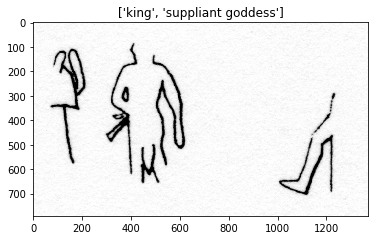

In [116]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/pics'
diganes = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50)

image, labels = diganes[222]
diganes.show_image(image, labels)

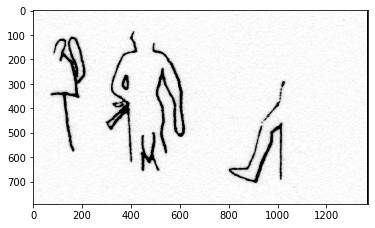

In [117]:
transform = RandomPermutation(cache_dir='/Users/atad/Desktop/DIGANES/pics')
per = transform(image)
plt.imshow(per)

In [118]:
image_size = 224

permutation_transofrm = RandomPermutation(cache_dir='/Users/atad/Desktop/DIGANES/pics')

transform = transforms.Compose(
    [permutation_transofrm,
     transforms.Resize((image_size, image_size)), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.49191375, 0.48235852, 0.44673872], 
                          std=[0.24706447, 0.24346213, 0.26147554])])

complete_dataset = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50, transform=transform)

N = len(complete_dataset)
train_size = int(N*0.8)
val_size = int(N*0.1)
test_size = N - (train_size + val_size)

train_set, val_set, test_set = torch.utils.data.random_split(complete_dataset, [train_size, val_size, test_size])

dataset = (train_set, val_set, test_set,)

In [119]:
# We first load the model and have a look at the different parts of the network

# load the pretrained model
pretrained_model = torchvision.models.mobilenet_v2(pretrained=True)

# features
print('Conv feature extractor:')
print(pretrained_model.features)
# classifier
print('Classification head:')
print(pretrained_model.classifier)

Conv feature extractor:
Sequential(
  (0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [120]:
feature_extractor = pretrained_model.features

torchsummary.summary(feature_extractor, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [121]:
class PretrainedClassifier(nn.Module): 
    def __init__(self, pretrained=True):
        super().__init__()

        if pretrained:
            self.feature_extractor = feature_extractor
            # We only freeze the parameters of the 10 low-level convolutional bottlenecks.
            for param in self.feature_extractor[0:10].parameters():
                param.requires_grad = False
        else:
            self.feature_extractor = torchvision.models.mobilenet_v2(pretrained=False).features
        
        # Pooling is reliant on the input image size, e.g. for size 64 => (2, 2).
        self.avg_pool = nn.AvgPool2d((7, 7))
        
        self.classifier = nn.Linear(in_features=1280, out_features=len(complete_dataset.classes), bias=True)
        
    def forward(self, x): 
        x = self.feature_extractor(x)
        x = self.avg_pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        
        return x

In [122]:
# Feel free to change the hyperparameters here!
hparams = {
    "batch_size": 64,
    "learning_rate": 3e-4,
}

finetune_model = PretrainedClassifier(pretrained=True)

model = MyPytorchModel(hparams, dataset, finetune_model)

In [ ]:
trainer = None

trainer = pl.Trainer(
    max_epochs=2,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

    | Name                                | Type                 | Params
-------------------------------------------------------------------------
0   | model                               | PretrainedClassifier | 2 M   
1   | model.feature_extractor             | Sequential           | 2 M   
2   | model.feature_extractor.0           | ConvBNReLU           | 928   
3   | model.feature_extractor.0.0         | Conv2d               | 864   
4   | model.feature_extractor.0.1         | BatchNorm2d          | 64    
5   | model.feature_extractor.0.2         | ReLU6                | 0     
6   | model.feature_extractor.1           | InvertedResidual     | 896   
7   | model.feature_extractor.1.conv      | Sequential           | 896   
8   | model.feature_extractor.1.conv.0    | ConvBNReLU           | 352   
9   | model.feature_extractor.1.conv.0.0  | Conv2d               | 288   
10  | model.feature_

Val-Acc=13.582191780821917


/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [27]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 8008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
E0803 15:02:50.942229 4778220992 program.py:226] TensorBoard could not bind to port 8008, it was already in use
ERROR: TensorBoard could not bind to port 8008, it was already in use

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

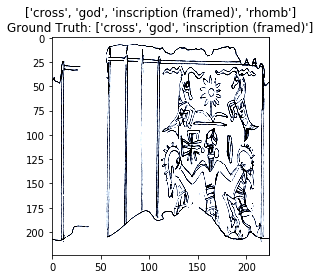

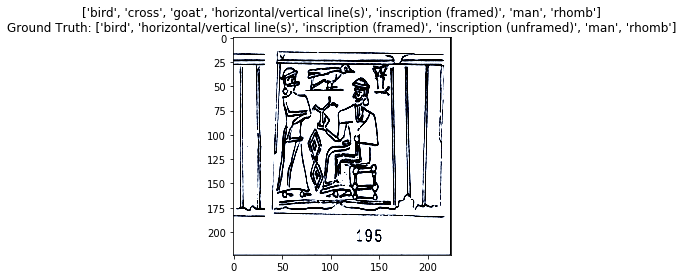

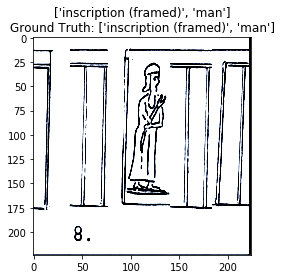

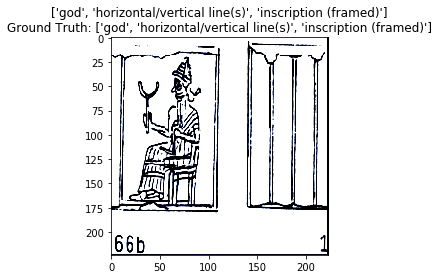

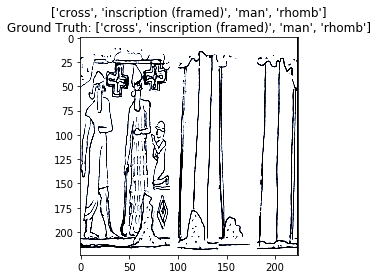

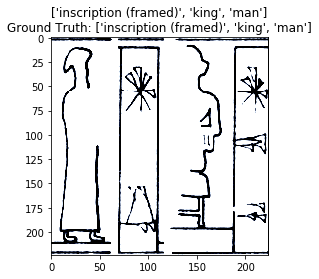

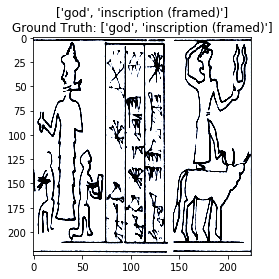

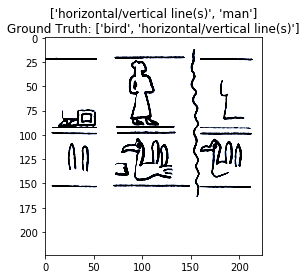

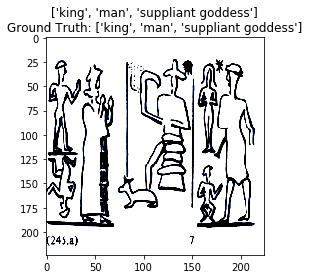

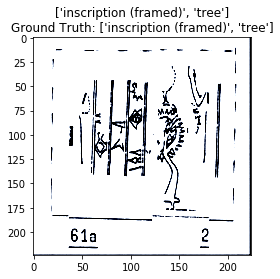

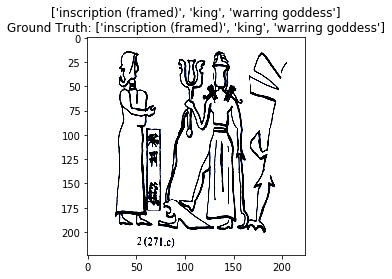

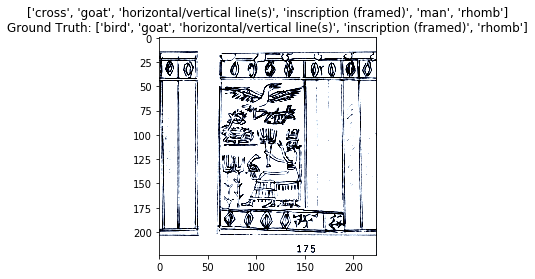

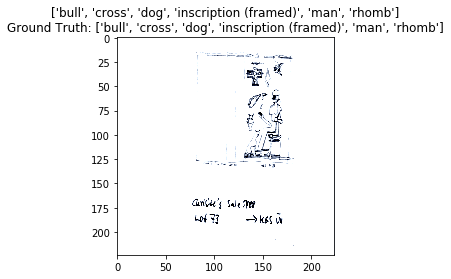

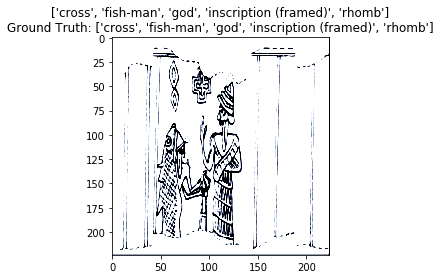

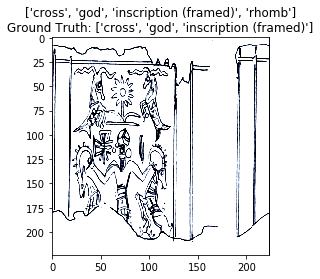

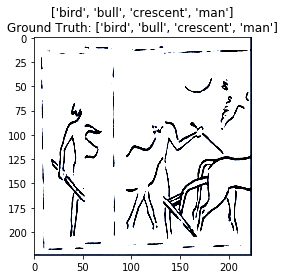

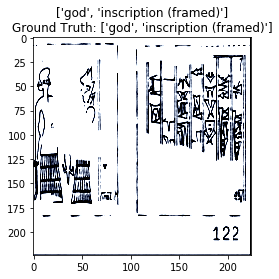

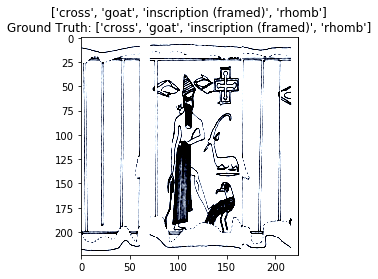

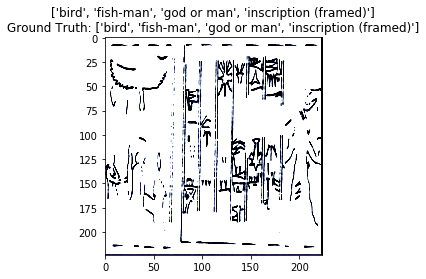

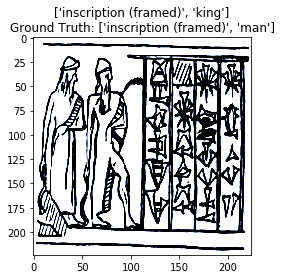

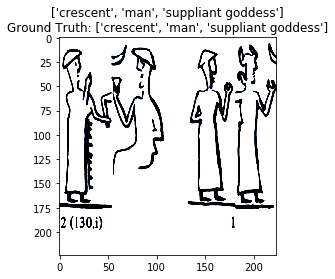

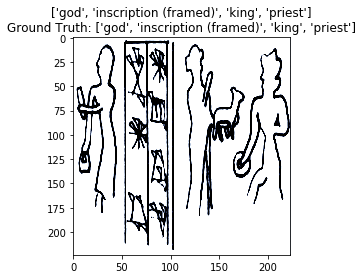

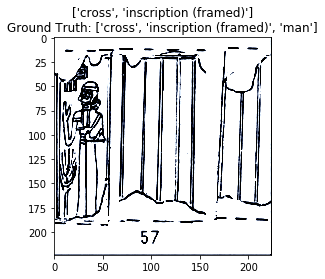

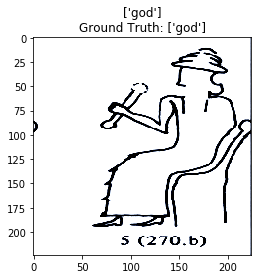

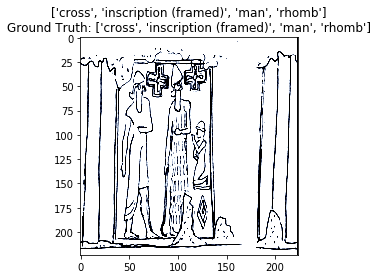

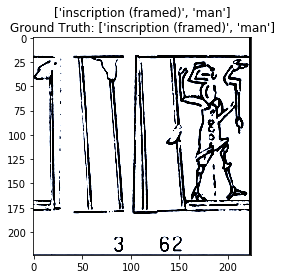

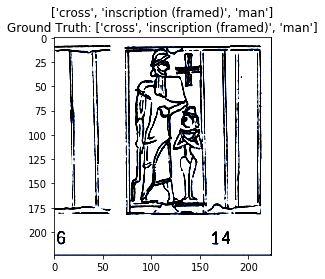

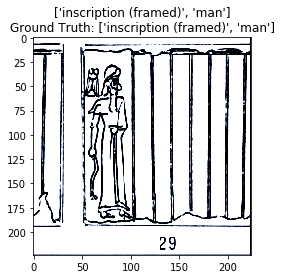

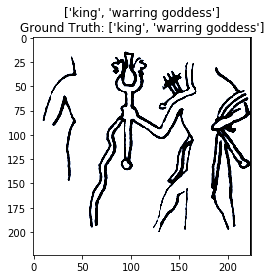

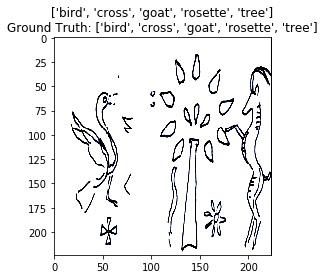

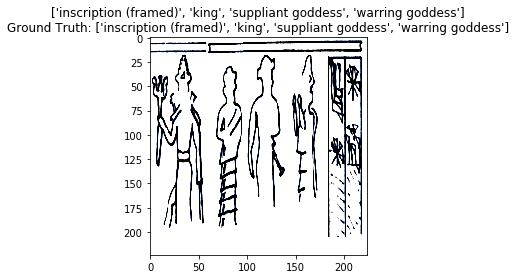

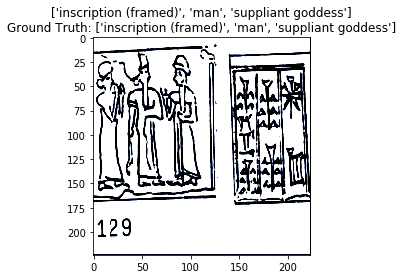

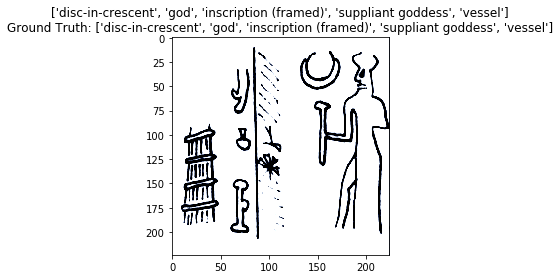

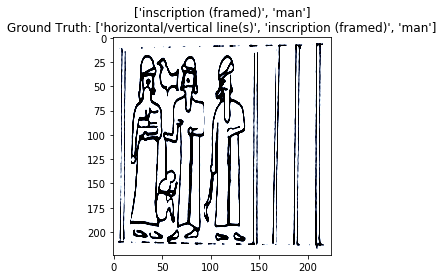

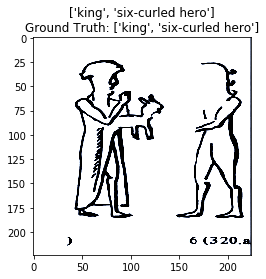

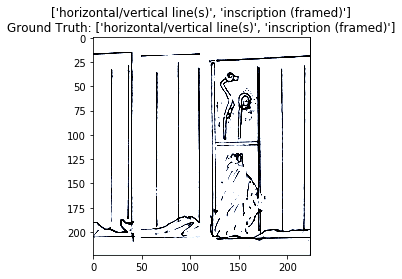

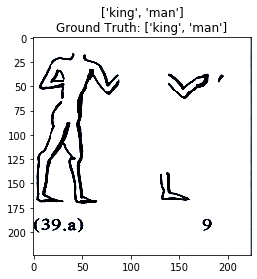

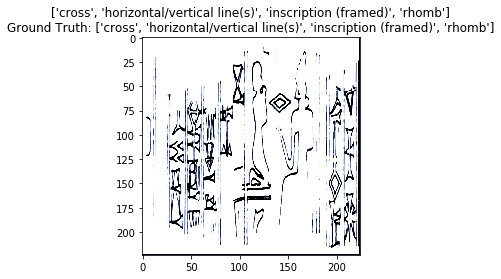

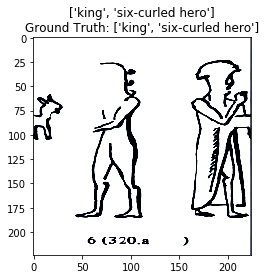

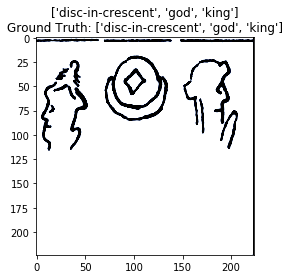

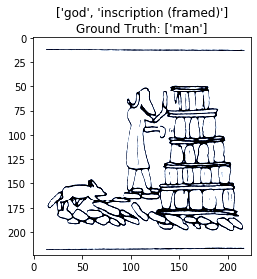

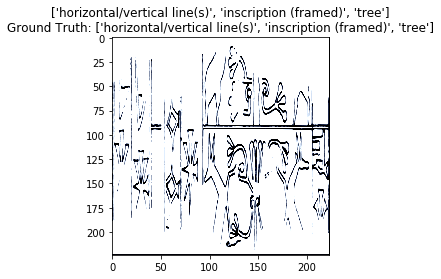

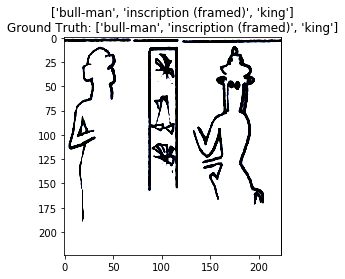

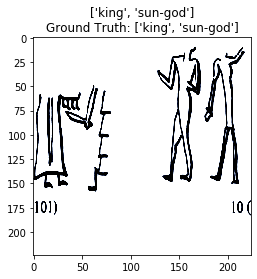

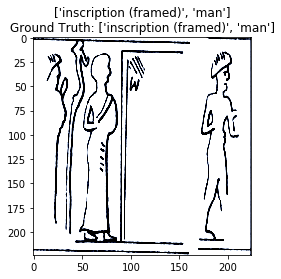

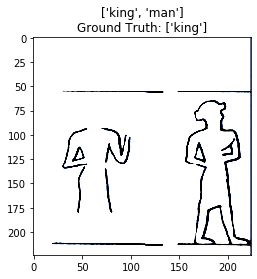

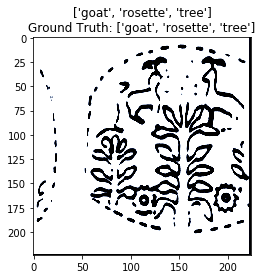

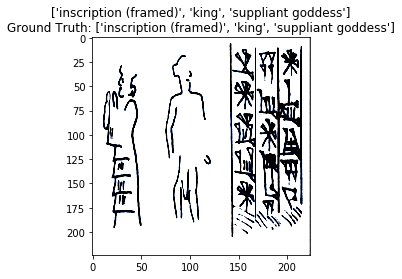

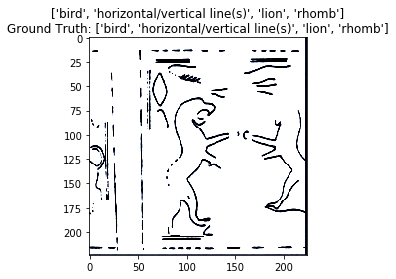

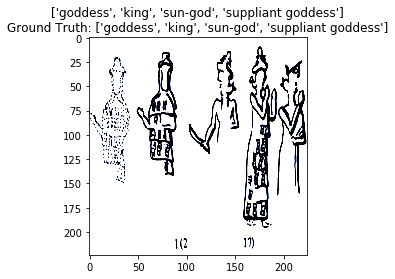

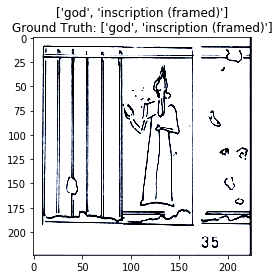

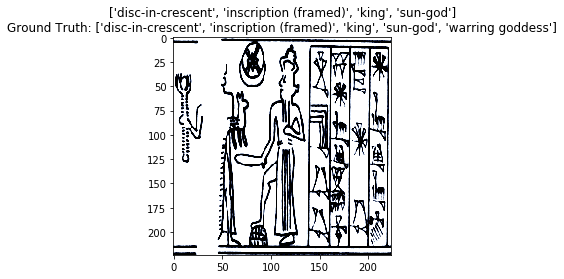

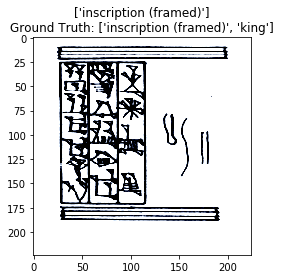

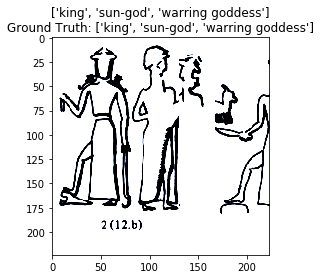

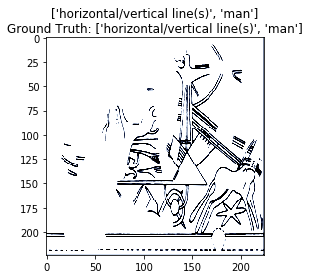

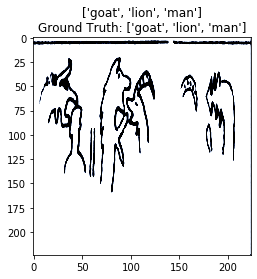

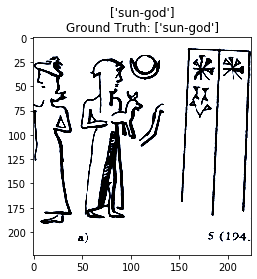

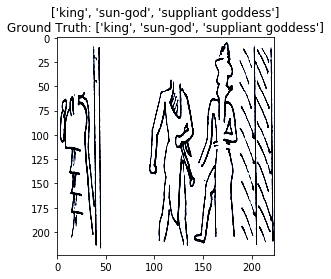

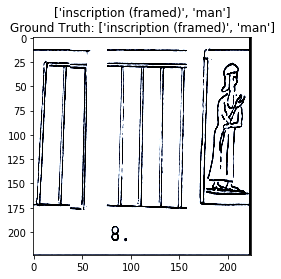

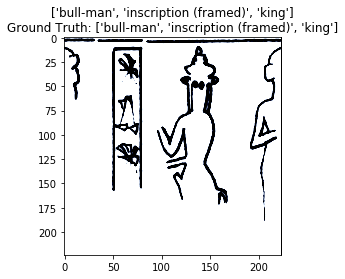

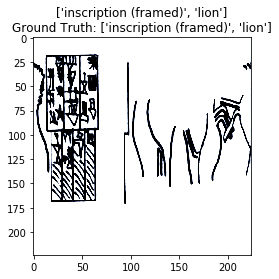

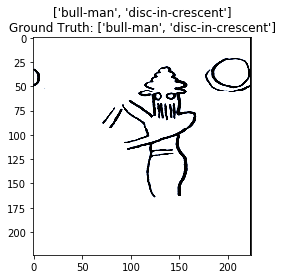

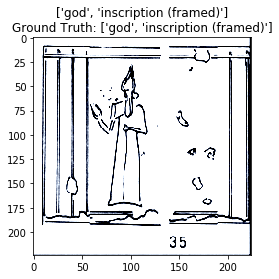

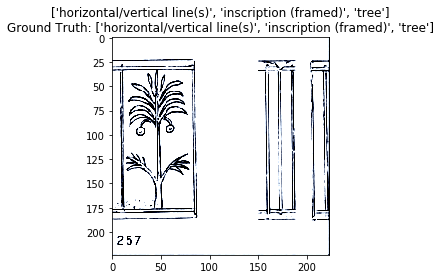

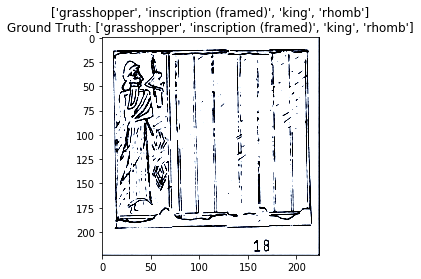

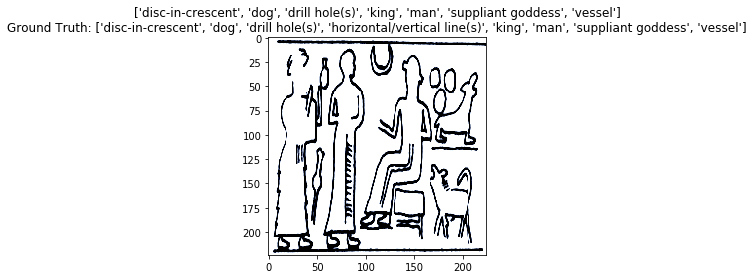

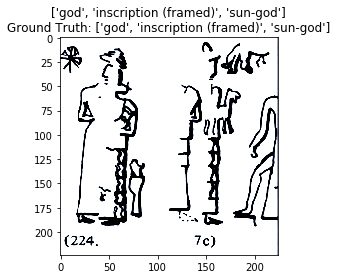

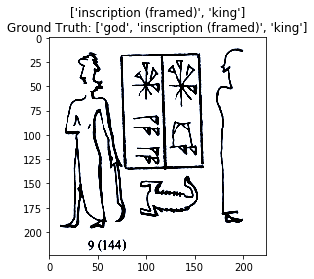

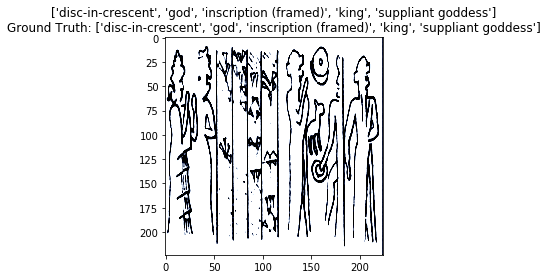

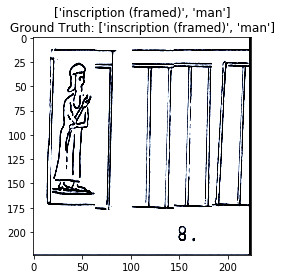

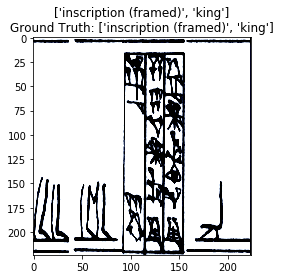

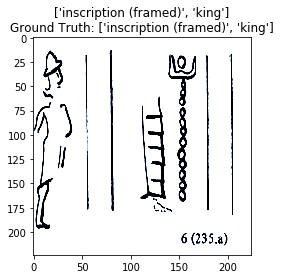

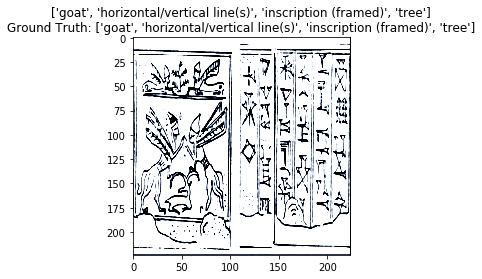

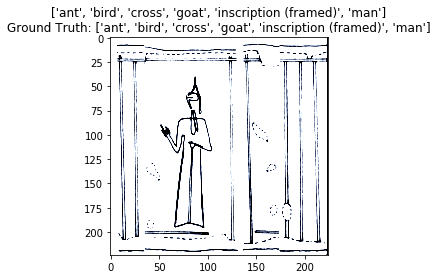

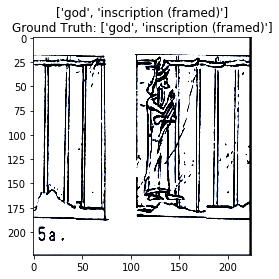

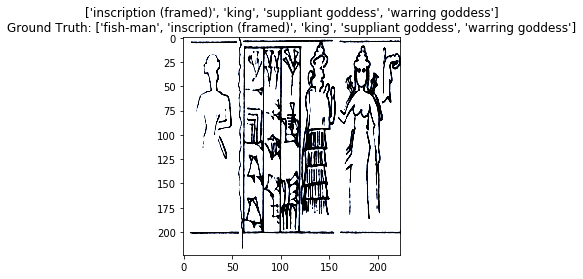

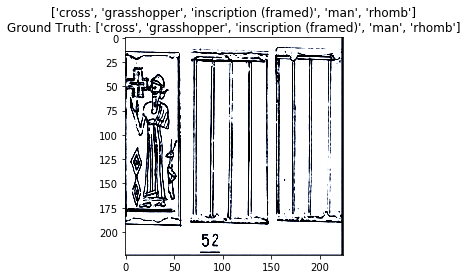

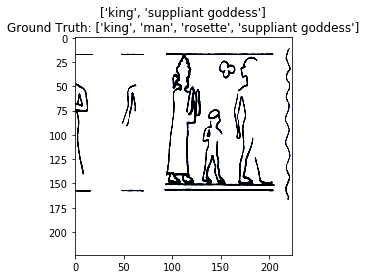

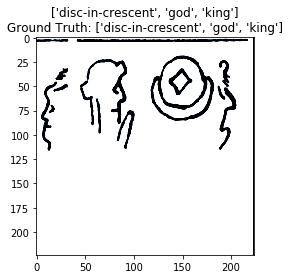

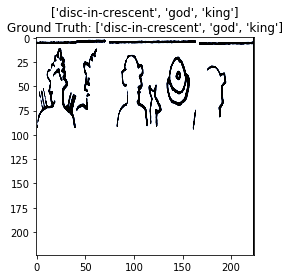

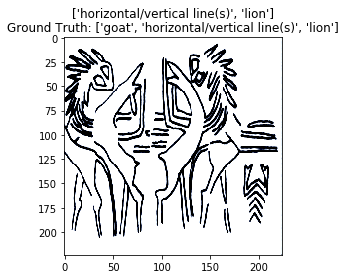

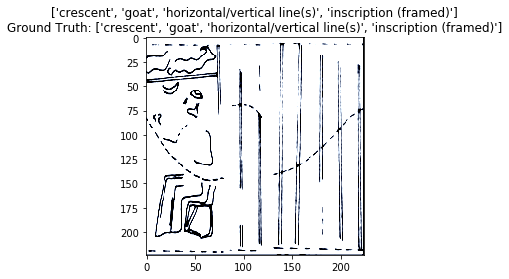

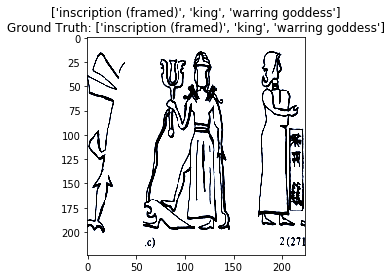

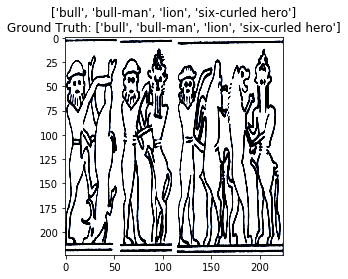

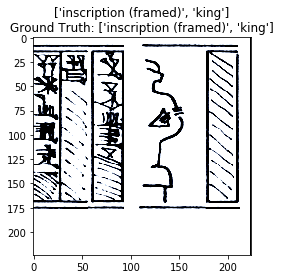

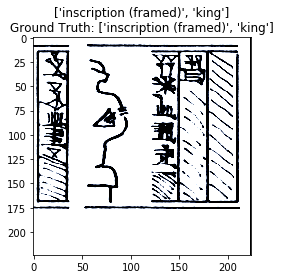

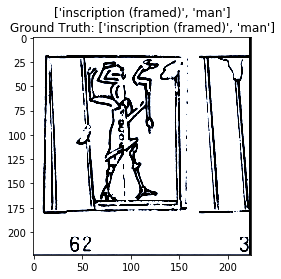

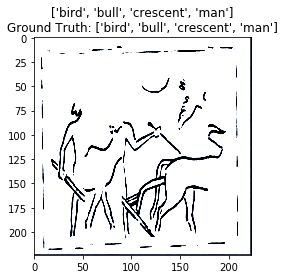

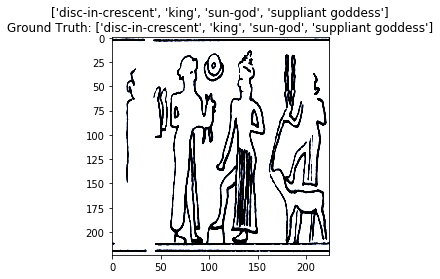

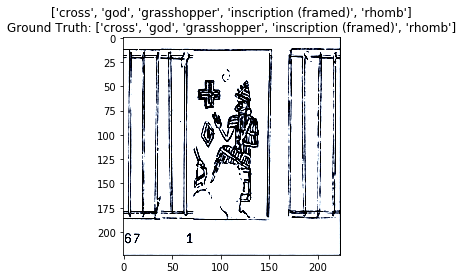

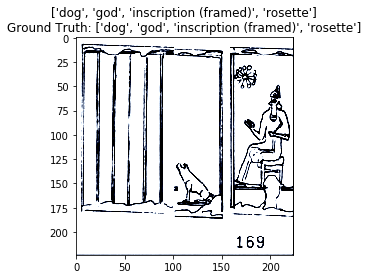

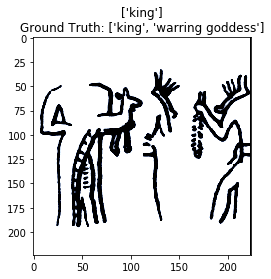

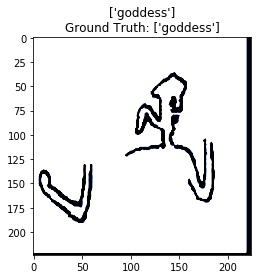

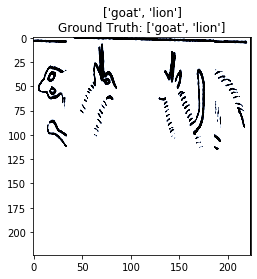

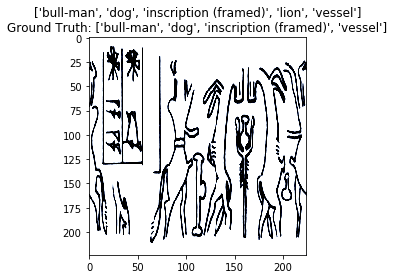

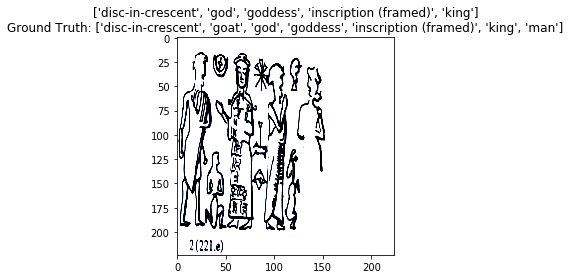

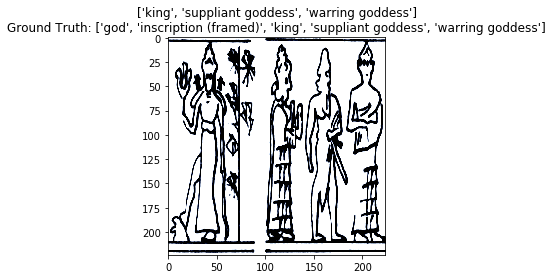

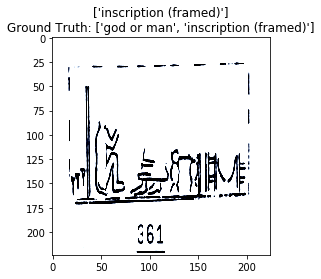

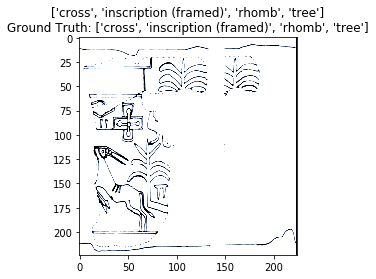

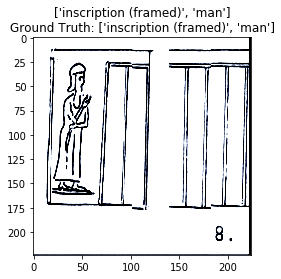

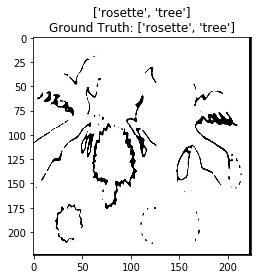

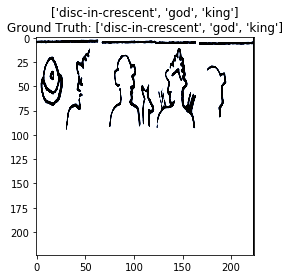

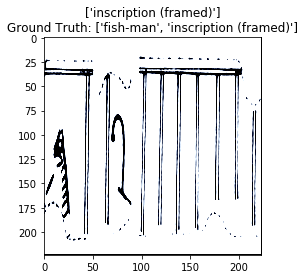

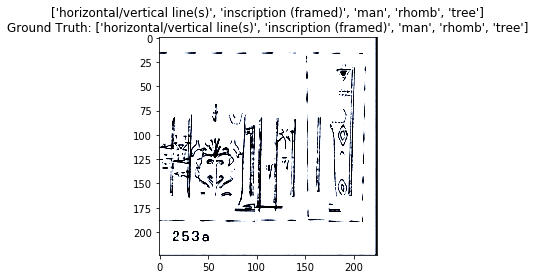

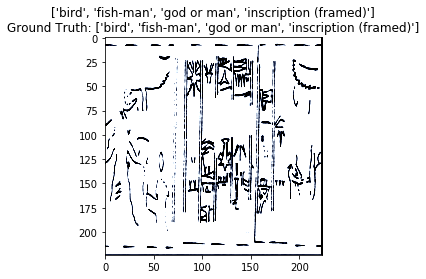

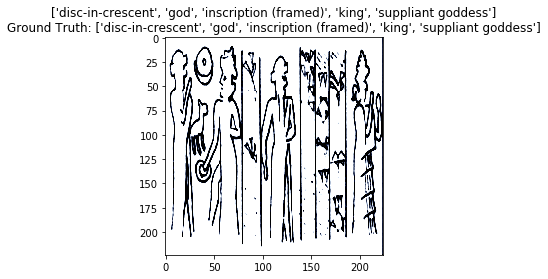

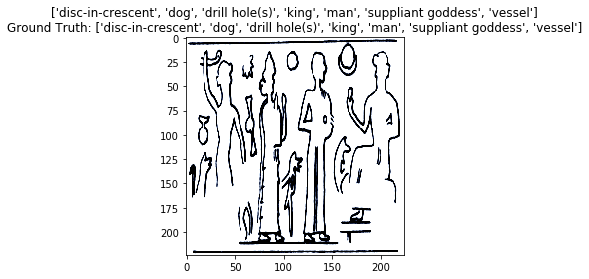

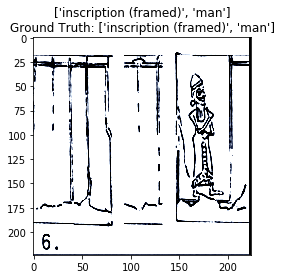

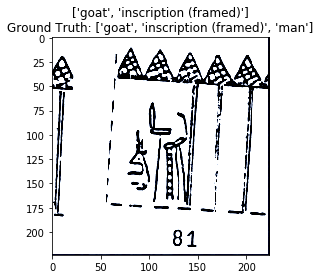

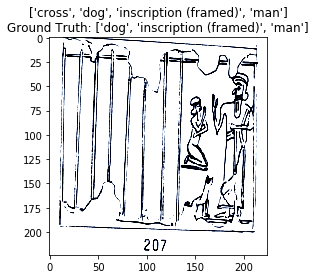

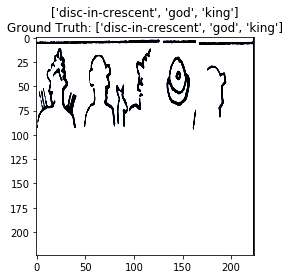

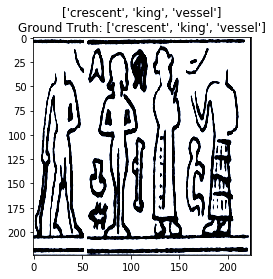

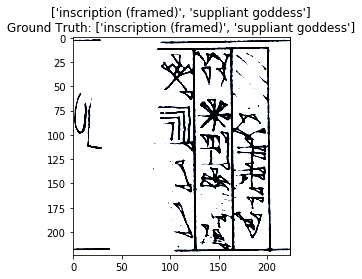

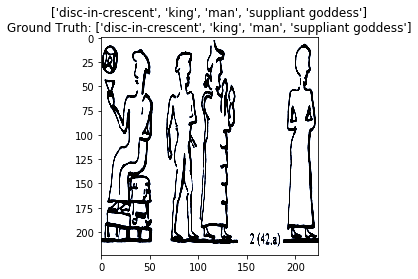

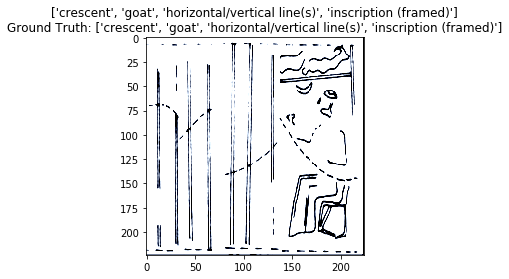

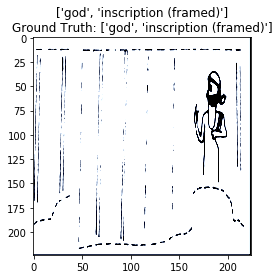

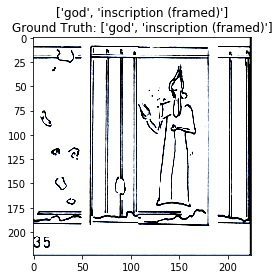

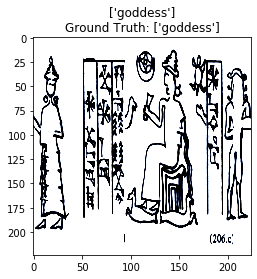

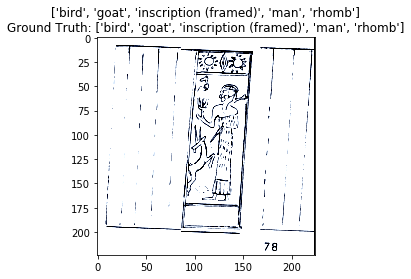

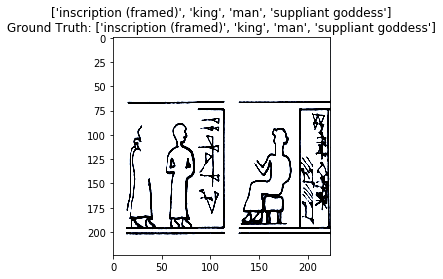

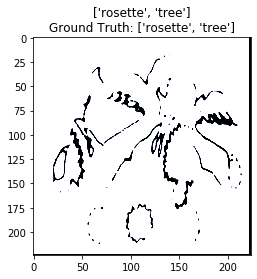

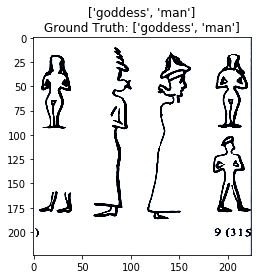

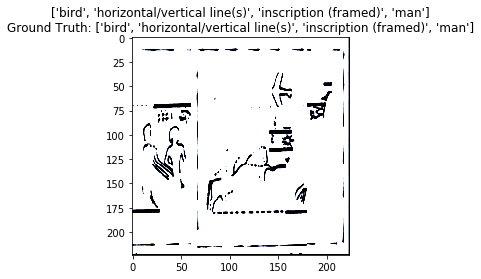

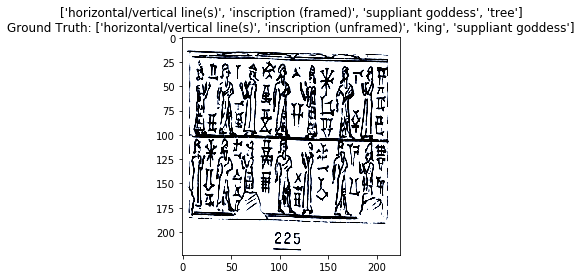

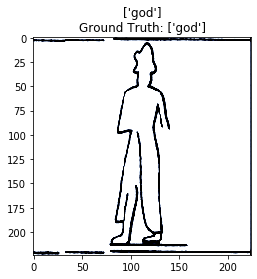

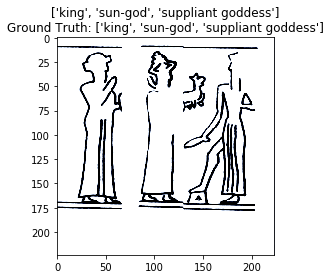

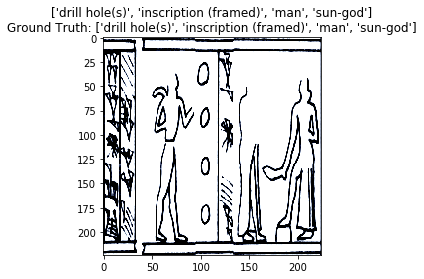

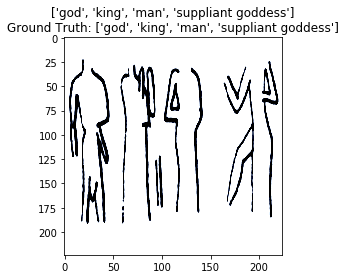

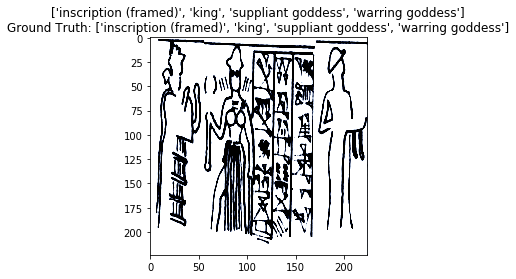

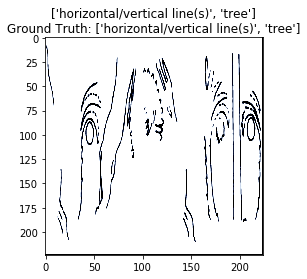

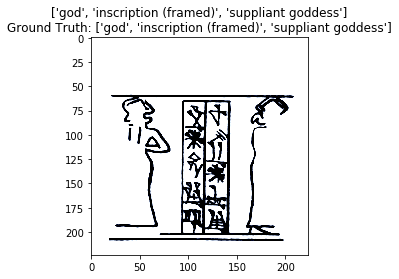

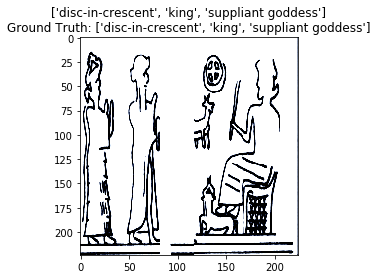

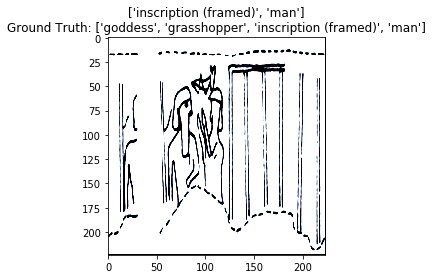

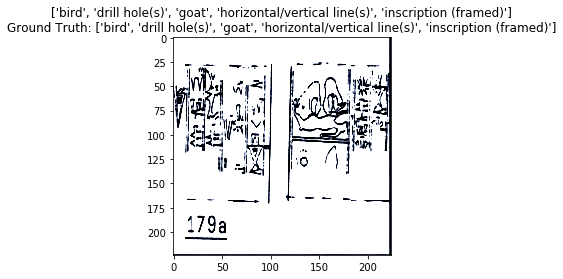

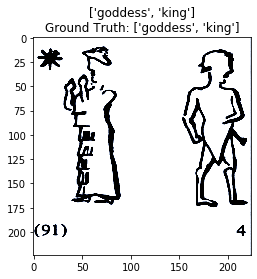

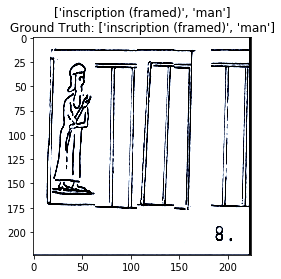

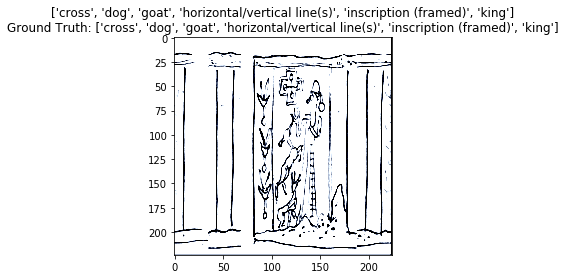

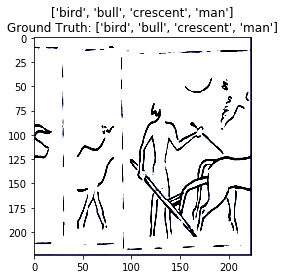

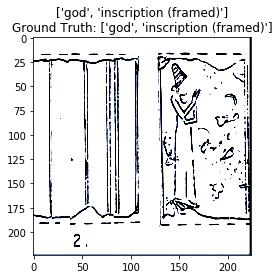

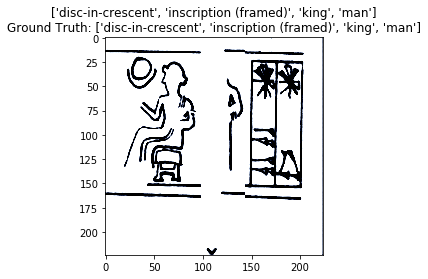

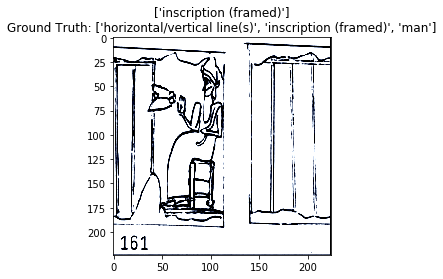

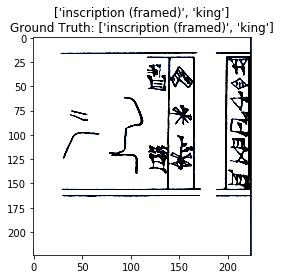

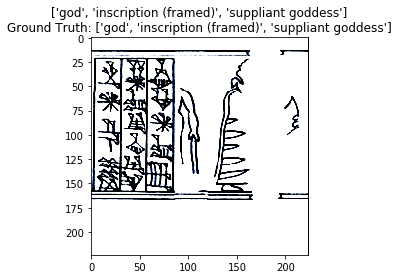

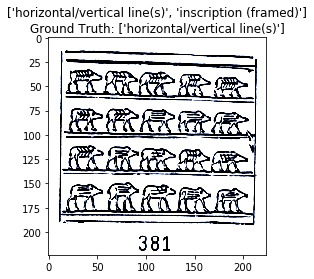

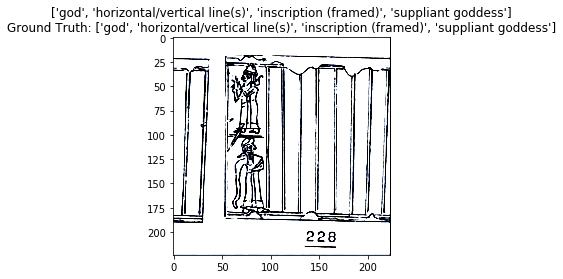

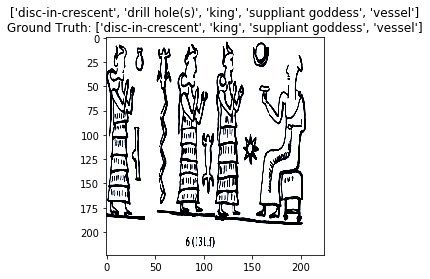

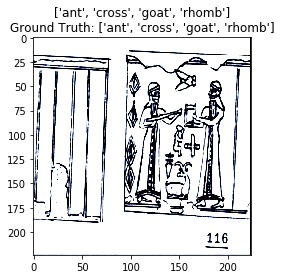

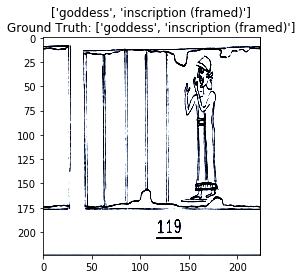

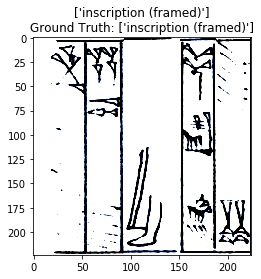

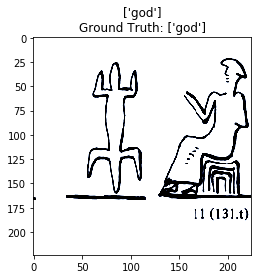

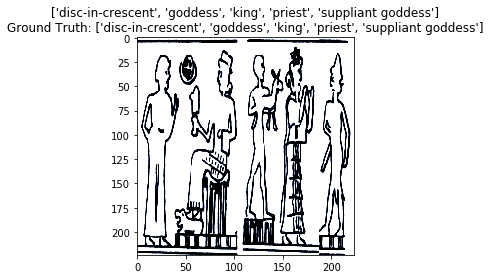

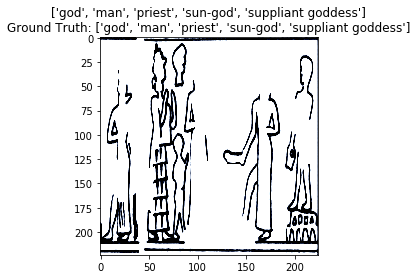

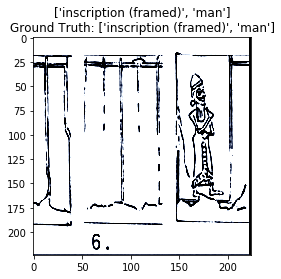

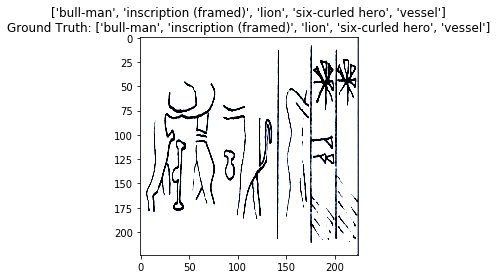

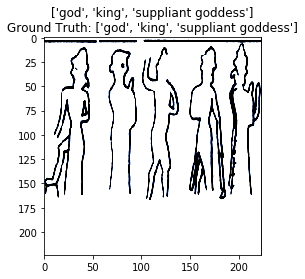

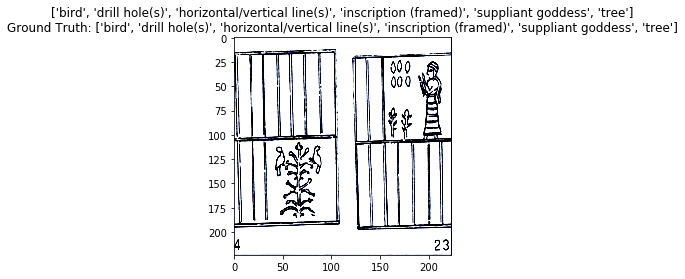

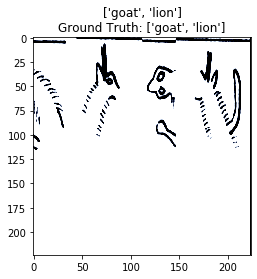

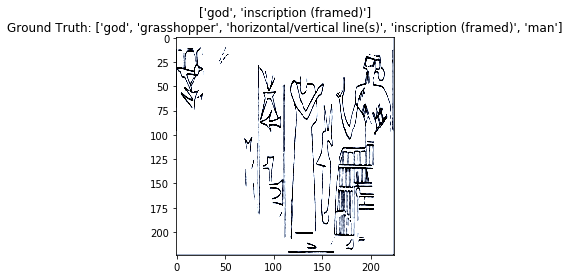

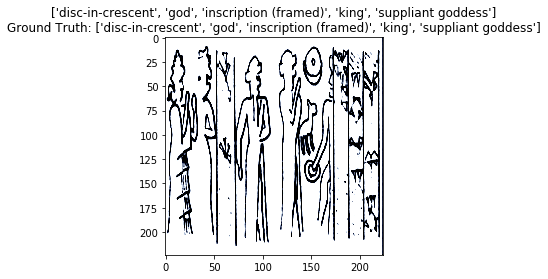

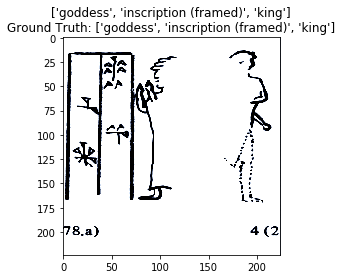

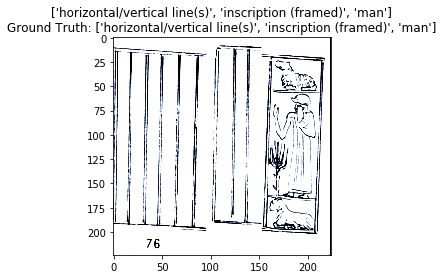

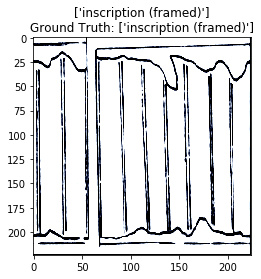

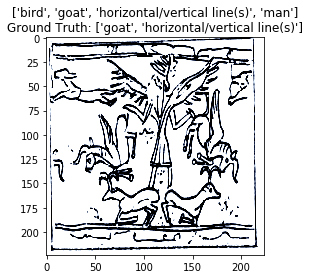

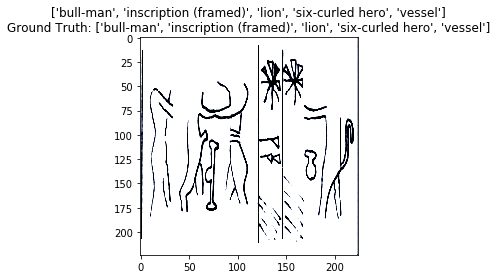

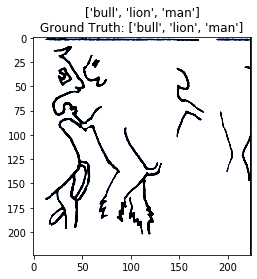

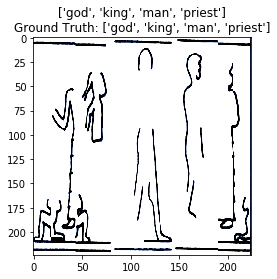

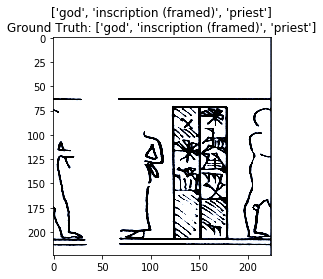

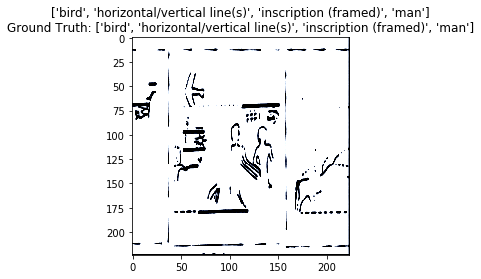

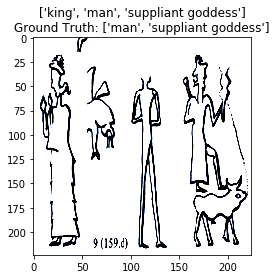

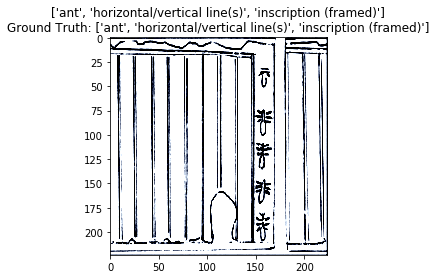

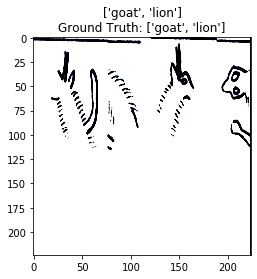

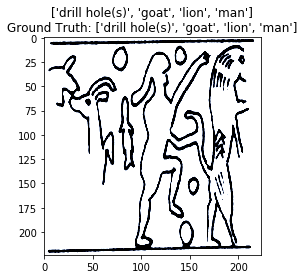

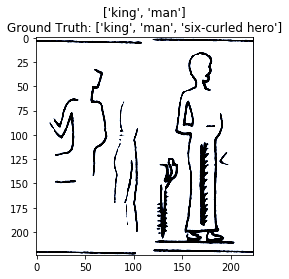

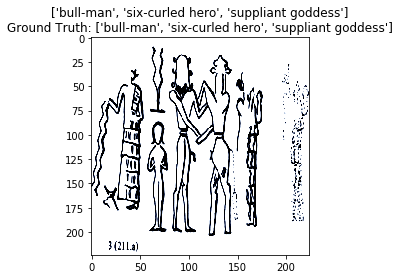

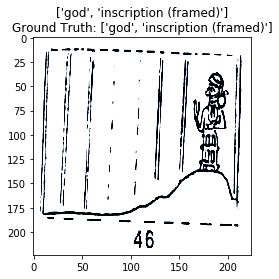

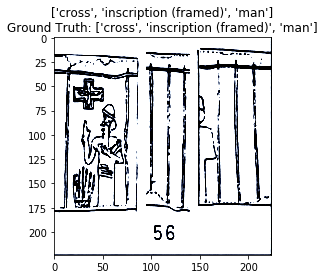

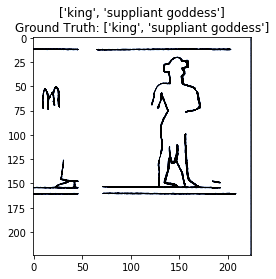

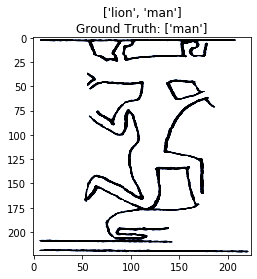

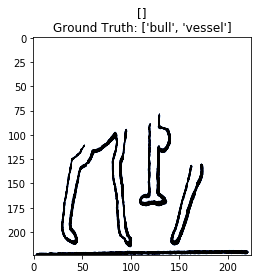

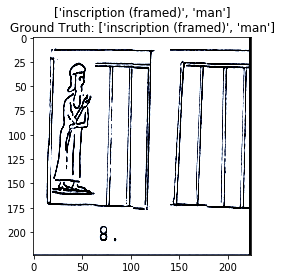

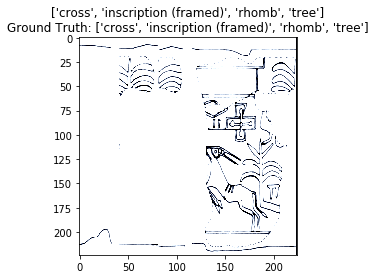

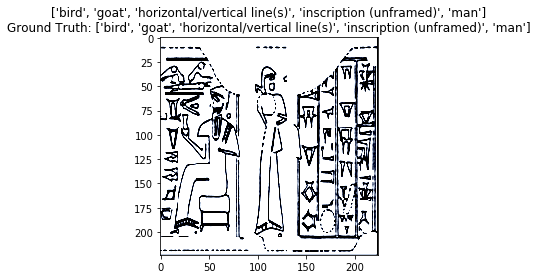

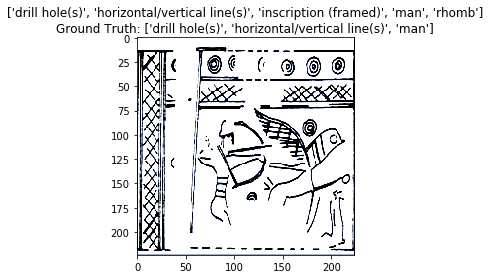

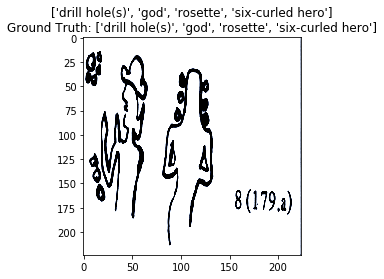

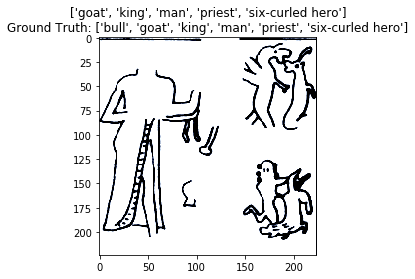

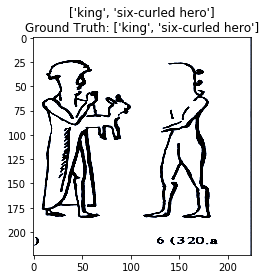

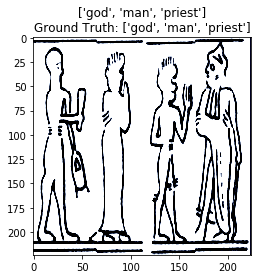

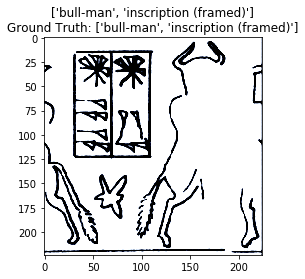

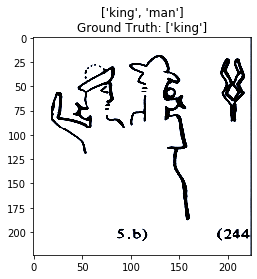

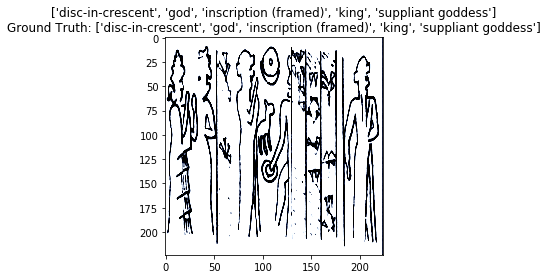

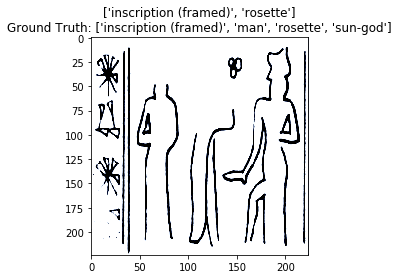

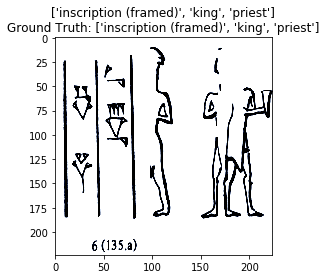

In [106]:
model.eval()
count = 0
for batch in model.test_dataloader():
    X, y = batch

    score = model.forward(X)
    preds = (torch.sigmoid(score).data > 0.5).float()
    
    n_correct = f1_score(y ,preds, average="samples") * X.shape[0]
    
    for i in range(X.shape[0]):
        dig_dataset.show_image(X[i], preds[i], y[i])
    if count == 2:
        break
    count+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


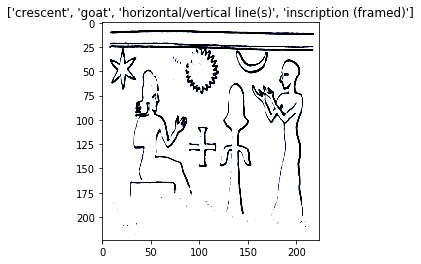

In [86]:
model.eval()
image = Image.open('test4.jpg').convert('RGB')
image = transform(image)
X = image.reshape((1, 3, 224, 224))

score = model.forward(X)
preds = (torch.sigmoid(score).data > 0.5).float()
dig_dataset.show_image(image, preds[0])

In [100]:
torch.save(model, "mobilenet_v2_model.pt")
#pickle.dump


TypeError: can't pickle _thread.lock objects